# Data loading - check to correctly understand data / label format

- load data from confocal boundary example dataset
- watch how data changes formats / shapes throughout the training pipeline.

- details:  
 - pytorch always uses the pattern: raw data -> Dataset -> DataLoader, and the DataLoader is in turn fed to the model.
 - when the Dataset object is being created, the original raw volumes are (somehow?) randomly subsampled into many volume patches, on which the model is ultimately trained.
 

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pytorch3dunet
import pytorch3dunet.unet3d as u3  # !
from pytorch3dunet import predict
from pytorch3dunet import train

from pytorch3dunet.unet3d import trainer as trainer
from pytorch3dunet.unet3d.config import _load_config_yaml

from torchsummary import summary
import torch
from torch.utils.data import Dataset, DataLoader


# these lines are required to test dataset / dataloader code from datasets.utils
from pytorch3dunet.unet3d.utils import get_logger, get_class
from pytorch3dunet.datasets.utils import _loader_classes, get_slice_builder
logger = get_logger('Dataset') 

In [50]:
sam = True  # (False if ben) thinking we could maintain different filepaths here -- or we could copy the whole notebook and maintain two different working notebooks.

if sam:
    
    config_dir = './3DUnet_confocal_boundary'
    test_config_filename = 'test_config.yml'
    train_config_filename = 'train_config.yml'

os.listdir(config_dir)

['test_config.yml',
 'test_config.yml~',
 'ovules_raw.png',
 'ovules_pred.png',
 'train_config.yml']

In [51]:
train_config_fp = '/scratch/groups/jyeatman/samjohns-projects/unet3d/pytorch-3dunet/resources/3DUnet_confocal_boundary/train_config.yml'

In [52]:
train_config = _load_config_yaml(train_config_fp)
train_config['loss']

{'name': 'BCEDiceLoss', 'ignore_index': None, 'skip_last_target': True}

In [55]:
config_filepath = f'{config_dir}/{test_config_filename}'
test_config = _load_config_yaml(config_filepath)
test_config

{'model_path': 'PATH_TO_BEST_CHECKPOINT',
 'model': {'name': 'UNet3D',
  'in_channels': 1,
  'out_channels': 1,
  'layer_order': 'gcr',
  'f_maps': 32,
  'num_groups': 8,
  'final_sigmoid': True},
 'predictor': {'name': 'StandardPredictor'},
 'loaders': {'output_dir': '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/test-checkpoints',
  'batch_size': 1,
  'num_workers': 2,
  'test': {'file_paths': ['/scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test'],
   'slice_builder': {'name': 'SliceBuilder',
    'patch_shape': [80, 170, 170],
    'stride_shape': [40, 90, 90]},
   'transformer': {'raw': [{'name': 'Standardize'},
     {'name': 'ToTensor', 'expand_dims': True}]}}}}

In [13]:
config['model_path']

'PATH_TO_BEST_CHECKPOINT'

In [14]:
config['loaders']

{'output_dir': '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/test-checkpoints',
 'batch_size': 1,
 'num_workers': 2,
 'test': {'file_paths': ['/scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test'],
  'slice_builder': {'name': 'SliceBuilder',
   'patch_shape': [80, 170, 170],
   'stride_shape': [40, 90, 90]},
  'transformer': {'raw': [{'name': 'Standardize'},
    {'name': 'ToTensor', 'expand_dims': True}]}}}

In [46]:
fp = ds_test[0].file_path

In [49]:
import h5py

test_h5 = h5py.File(fp, 'r')

test_h5_raw_np = np.array(test_h5.get('raw'))
test_h5_label_np = np.array(test_h5.get('label'))

raw_shape = test_h5_raw_np.shape
label_shape = test_h5_label_np.shape

raw_shape, label_shape

((260, 810, 715), (260, 810, 715))

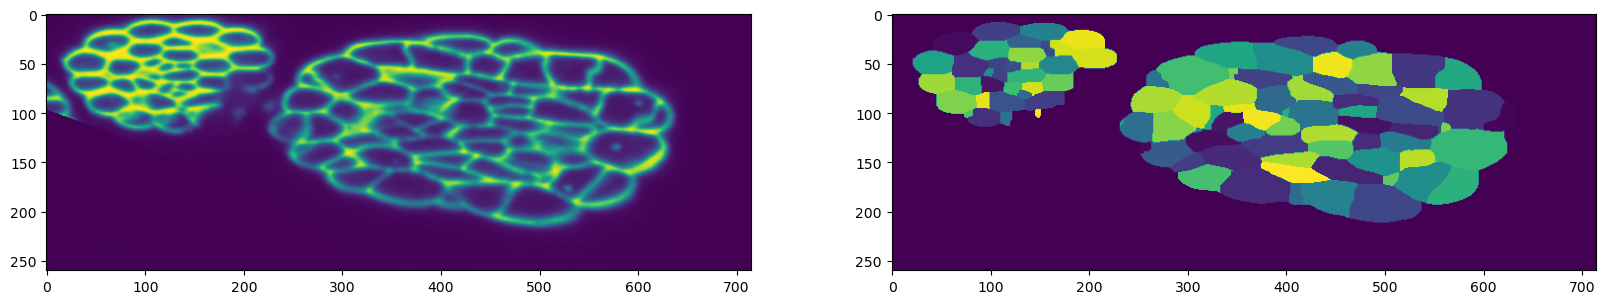

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(test_h5_raw_np[:, 150])  # order: Z, Y, X -- slice along Y
ax[1].imshow(test_h5_label_np[:, 150])

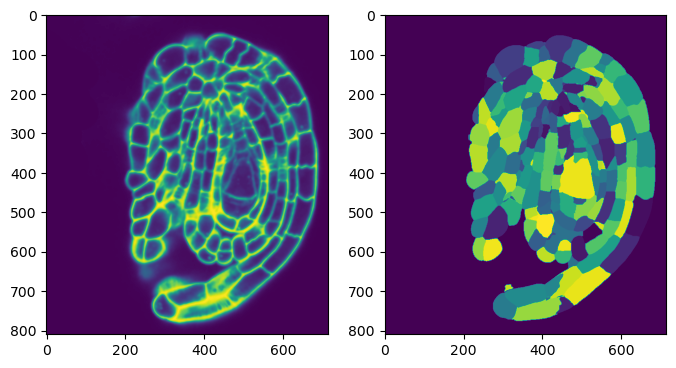

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(8, 16))
ax[0].imshow(test_h5_raw_np[150])  # order: Z, Y, X -- slice along Z
ax[1].imshow(test_h5_label_np[150])

In [117]:
np.unique(test_h5_label_np, return_counts=True)

(array([   0,    3,    4, ..., 1446, 1449, 1450], dtype=uint16),
 array([105043165,     37788,      9032, ...,     15003,     33326,
            10450]))

In [16]:
class StandardHDF5Dataset(AbstractHDF5Dataset):
    """
    Implementation of the HDF5 dataset which loads the data from the H5 files into the memory.
    Fast but might consume a lot of memory.
    """

    def __init__(self, file_path, phase, slice_builder_config, transformer_config,
                 raw_internal_path='raw', label_internal_path='label', weight_internal_path=None,
                 global_normalization=True):
        super().__init__(file_path=file_path, phase=phase, slice_builder_config=slice_builder_config,
                         transformer_config=transformer_config, raw_internal_path=raw_internal_path,
                         label_internal_path=label_internal_path, weight_internal_path=weight_internal_path,
                         global_normalization=global_normalization)

    @staticmethod
    def create_h5_file(file_path):
        return h5py.File(file_path, 'r')

NameError: name 'AbstractHDF5Dataset' is not defined

In [9]:
# original logic that loads h5 files and makes them into pytorch Dataset objects
# from l. 125 of datasets.hdf5

def create_datasets(cls, dataset_config, phase):
    phase_config = dataset_config[phase]

    # load data augmentation configuration
    transformer_config = phase_config['transformer']
    # load slice builder config
    slice_builder_config = phase_config['slice_builder']
    # load files to process
    file_paths = phase_config['file_paths']
    # file_paths may contain both files and directories; if the file_path is a directory all H5 files inside
    # are going to be included in the final file_paths
    file_paths = cls.traverse_h5_paths(file_paths)

    datasets = []
    for file_path in file_paths:
        try:
            logger.info(f'Loading {phase} set from: {file_path}...')
            dataset = cls(file_path=file_path,
                          phase=phase,
                          slice_builder_config=slice_builder_config,
                          transformer_config=transformer_config,
                          raw_internal_path=dataset_config.get('raw_internal_path', 'raw'),
                          label_internal_path=dataset_config.get('label_internal_path', 'label'),
                          weight_internal_path=dataset_config.get('weight_internal_path', None),
                          global_normalization=dataset_config.get('global_normalization', None))
            datasets.append(dataset)
        except Exception:
            logger.error(f'Skipping {phase} set: {file_path}', exc_info=True)
    return datasets

In [10]:
# hdf5 -> torch.Tensor logic
# original definition on l. 227 of datasets.utils

def get_test_dataset(config):
    """
    Returns test Dataset.

    :return: Dataset objects
    """

    assert 'loaders' in config, 'Could not find data loaders configuration'
    loaders_config = config['loaders']

    logger.info('Creating test set loaders...')

    # get dataset class
    dataset_cls_str = loaders_config.get('dataset', None)
    if dataset_cls_str is None:
        dataset_cls_str = 'StandardHDF5Dataset'
        logger.warning(f"Cannot find dataset class in the config. Using default '{dataset_cls_str}'.")
    dataset_class = _loader_classes(dataset_cls_str)

    test_datasets = dataset_class.create_datasets(loaders_config, phase='test')
    return test_datasets
    
    
def get_test_loaders(test_datasets, config):
    """ Given a test_dataset, wrap it in a DataLoader and return
        the dataloaders.
    """
    loaders_config = config['loaders']
    num_workers = loaders_config.get('num_workers', 1)
    logger.info(f'Number of workers for the dataloader: {num_workers}')

    batch_size = loaders_config.get('batch_size', 1)
    if torch.cuda.device_count() > 1 and not config['device'].type == 'cpu':
        logger.info(
            f'{torch.cuda.device_count()} GPUs available. Using batch_size = {torch.cuda.device_count()} * {batch_size}')
        batch_size = batch_size * torch.cuda.device_count()

    logger.info(f'Batch size for dataloader: {batch_size}')

    # use generator in order to create data loaders lazily one by one
    for test_dataset in test_datasets:
        logger.info(f'Loading test set from: {test_dataset.file_path}...')
        if hasattr(test_dataset, 'prediction_collate'):
            collate_fn = test_dataset.prediction_collate
        else:
            collate_fn = default_prediction_collate

        yield DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
                         collate_fn=collate_fn)

In [12]:
train_fp = '../../data/osfstorage-archive-train'
train_h5s = os.listdir(train_fp)
train_h5 = train_h5s[0]
train_h5s

['N_487_ds2x.h5',
 'N_509_ds2x.h5',
 'N_416_ds2x.h5',
 'N_449_ds2x.h5',
 'N_404_ds2x.h5',
 'N_512_ds2x.h5',
 'N_457_ds2x.h5',
 'N_450_ds2x.h5',
 'N_451_ds2x.h5',
 'N_535_ds2x.h5',
 'N_517_ds2x.h5',
 'N_422_ds2x.h5',
 'N_428_ds2x.h5',
 'N_405_B_ds2x.h5',
 'N_440_ds2x.h5',
 'N_534_ds2x.h5',
 'N_458_ds2x.h5',
 'N_425_ds2x.h5',
 'N_445_ds2x.h5',
 'N_454_ds2x.h5',
 'N_405_A_ds2x.h5',
 'N_536_ds2x.h5']

In [13]:
import h5py
file = h5py.File(f'{train_fp}/{train_h5}', 'r')

In [14]:
file.keys()

<KeysViewHDF5 ['label', 'label_with_ignore', 'raw']>

In [15]:
train_example_label = file['label']
train_example_raw = file['raw']


In [16]:
train_example_label_np = np.array(train_example_label)
train_example_raw_np = np.array(train_example_raw)

In [17]:
train_example_label_np.shape, train_example_raw_np.shape

((377, 1336, 1336), (377, 1336, 1336))

In [43]:
ds_test = get_test_dataset(test_config)

2023-05-18 14:40:11,172 [MainThread] INFO Dataset - Creating test set loaders...
2023-05-18 14:40:11,172 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2023-05-18 14:40:11,173 [MainThread] INFO HDF5Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_511_final_crop_ds2.h5...
2023-05-18 14:40:11,792 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [40, 90, 90]}
2023-05-18 14:40:11,793 [MainThread] INFO HDF5Dataset - Number of patches: 432
2023-05-18 14:40:11,794 [MainThread] INFO HDF5Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_435_final_crop_ds2.h5...
2023-05-18 14:40:14,628 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [40, 90, 90]}
2023-05-18 14:40:

In [20]:
dl_test = get_test_loaders(ds_test, test_config)

In [21]:
dl_tests = []
for dl in dl_test:
    dl_tests.append(dl)

2023-05-18 13:47:26,104 [MainThread] INFO Dataset - Number of workers for the dataloader: 2
2023-05-18 13:47:26,105 [MainThread] INFO Dataset - Batch size for dataloader: 1
2023-05-18 13:47:26,105 [MainThread] INFO Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_511_final_crop_ds2.h5...
2023-05-18 13:47:26,106 [MainThread] INFO Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_435_final_crop_ds2.h5...
2023-05-18 13:47:26,106 [MainThread] INFO Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_441_final_crop_ds2.h5...
2023-05-18 13:47:26,106 [MainThread] INFO Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_593_final_crop_ds2.h5...
2023-05-18 13:47:26,107 [MainThread] INFO Dataset - Loading test set from: /scratch/groups/jyeatman/sam

In [59]:
di0 = iter(dl_tests[0])

NameError: name 'dl_tests' is not defined

In [32]:
x, y = next(di0)
x.shape, y

(torch.Size([1, 1, 80, 170, 170]),
 ((slice(0, 80, None), slice(0, 170, None), slice(90, 260, None)),))

In [18]:
train_config_modified = train_config.copy()

In [19]:
train_config_modified['loss']

{'name': 'BCEDiceLoss', 'ignore_index': None, 'skip_last_target': True}

In [20]:
train_config_modified['transformer'] =  {'raw': [{'name': 'Standardize'},
     {'name': 'ToTensor', 'expand_dims': True}],
    'label': [{'name': 'RandomFlip'},
     {'name': 'RandomRotate90'},
     {'name': 'RandomRotate',
      'axes': [[2, 1]],
      'angle_spectrum': 45,
      'mode': 'reflect'},
     {'name': 'StandardLabelToBoundary', 'append_label': True},
     {'name': 'ToTensor', 'expand_dims': False}]}

In [21]:
train_config_modified['transformer']

{'raw': [{'name': 'Standardize'}, {'name': 'ToTensor', 'expand_dims': True}],
 'label': [{'name': 'RandomFlip'},
  {'name': 'RandomRotate90'},
  {'name': 'RandomRotate',
   'axes': [[2, 1]],
   'angle_spectrum': 45,
   'mode': 'reflect'},
  {'name': 'StandardLabelToBoundary', 'append_label': True},
  {'name': 'ToTensor', 'expand_dims': False}]}

In [22]:
trainer = u3.trainer.create_trainer(train_config_modified)

2023-05-18 15:48:37,914 [MainThread] INFO UNetTrainer - Number of learnable params 4081267
2023-05-18 15:48:37,914 [MainThread] INFO Dataset - Creating training and validation set loaders...
2023-05-18 15:48:37,915 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2023-05-18 15:48:38,429 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-train/N_487_ds2x.h5...
2023-05-18 15:48:44,433 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [20, 40, 40], 'threshold': 0.6, 'slack_acceptance': 0.01}
2023-05-18 15:49:30,184 [MainThread] INFO HDF5Dataset - Number of patches: 1647
2023-05-18 15:49:30,186 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-train/N_509_ds2x.h5...
2023-05-18 15:49:32,299 [MainThr

2023-05-18 15:54:16,251 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-train/N_425_ds2x.h5...
2023-05-18 15:54:19,436 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [20, 40, 40], 'threshold': 0.6, 'slack_acceptance': 0.01}
2023-05-18 15:54:34,313 [MainThread] INFO HDF5Dataset - Number of patches: 1116
2023-05-18 15:54:34,314 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-train/N_445_ds2x.h5...
2023-05-18 15:54:37,752 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [20, 40, 40], 'threshold': 0.6, 'slack_acceptance': 0.01}
2023-05-18 15:54:55,344 [MainThread] INFO HDF5Dataset - Number of patches: 1215
2023-05-18 15:54:55,346 [MainThread] INFO HDF5Dataset - Loading tr

/home/groups/jyeatman/software/anaconda3/envs/pytorch-3dunet/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
trainer.loss_criterion

SkipLastTargetChannelWrapper(
  (loss): BCEDiceLoss(
    (bce): BCEWithLogitsLoss()
    (dice): DiceLoss(
      (normalization): Sigmoid()
    )
  )
)

In [58]:
# Create the model
model = u3.model.get_model(config['model'])
model

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
     

In [57]:
pred = model(x)

NameError: name 'x' is not defined

In [74]:
x.shape, pred.shape
pred_np = pred.detach().numpy()

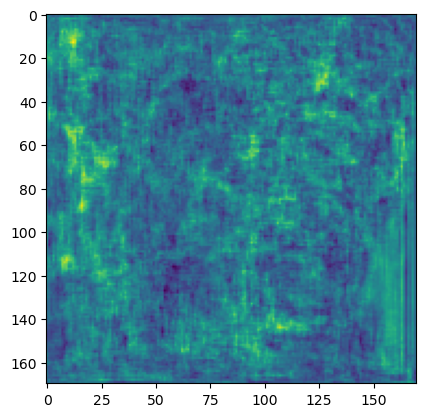

In [76]:
plt.imshow(pred_np[0, 0, 40])

In [45]:
summary(model, (1, 80, 170, 170))

NameError: name 'model' is not defined

In [49]:
test_dir = config['loaders']['test']['file_paths'][0]  # why so nested? eh, I guess I understand it...
f = h5py.File(test_dir, 'r')

NameError: name 'config' is not defined

In [46]:
tl = trainer.loaders['train']
ti = iter(tl)
t = next(ti)

In [47]:
input, target, weight = trainer._split_training_batch(t)

In [48]:
input.shape, target.shape, weight

(torch.Size([1, 1, 80, 170, 170]), torch.Size([1, 2, 80, 170, 170]), None)

In [62]:
output, loss = trainer._forward_pass(input, target, weight)
# train_losses.update(loss.item(), trainer._batch_size(input))

In [63]:
output.shape

torch.Size([1, 1, 80, 170, 170])

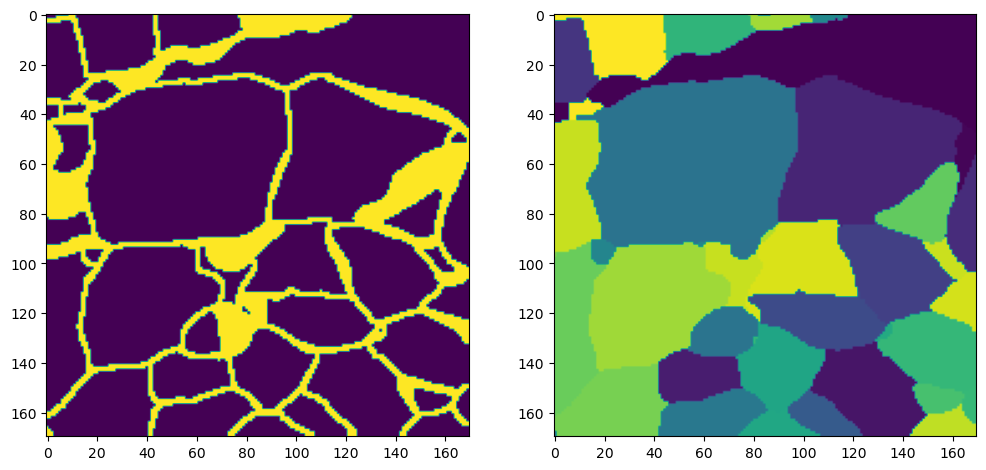

In [66]:
# visualize the two channels of 'target' (why two??)
target_np = target.detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(target_np[0, 0, 40])
ax[1].imshow(target_np[0, 1, 40])